In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import pickle
import numpy as np
import pandas as pd
import librosa
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
SAMPLE_RATE = 22050
N_FFT = 2048 #int(0.025 * SAMPLE_RATE)  # 25ms frame length
WIN_LENGTH = int(0.025 * SAMPLE_RATE)
HOP_LENGTH = 512 #int(0.010 * SAMPLE_RATE)     # 10ms hop length
N_MFCC = 20  # Number of cepstral coefficients to be extracted
N_MELS =40
DURATION = 30  # Duration of each audio file
NUM_SEGMENTS = 10  # Number of segments per audio file

In [4]:
file_path = "/content/drive/MyDrive/preprocess_new.pkl"

# Load data from pickle file
with open(file_path, "rb") as f:
    data = pickle.load(f)

In [5]:
def mfcc(audio) :
  mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)

  delta_mfcc = librosa.feature.delta(mfcc)
  delta2_mfcc = librosa.feature.delta(mfcc, order=2)
  concanated_mfcc = np.vstack((mfcc, delta_mfcc, delta2_mfcc))
  concanated_mfcc = concanated_mfcc.T
  return concanated_mfcc.tolist()


In [6]:
X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for i in range(len(data["train"]["features"])) :
    feature = data["train"]["features"][i]
    label = data["train"]["labels"][i]

    extraction = mfcc(feature)

    X_train.append(extraction)
    y_train.append(label)

for i in range(len(data["val"]["features"])) :
    feature = data["val"]["features"][i]
    label = data["val"]["labels"][i]

    extraction = mfcc(feature)

    X_val.append(extraction)
    y_val.append(label)

for i in range(len(data["test"]["features"])) :
    feature = data["test"]["features"][i]
    label = data["test"]["labels"][i]

    extraction = mfcc(feature)

    X_test.append(extraction)
    y_test.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)


(5832, 130, 60)
(729, 130, 60)
(729, 130, 60)


In [7]:
def build_model(input_shape):
    model = keras.Sequential()

    # First Bidirectional LSTM layer
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True), input_shape=input_shape))
    model.add(keras.layers.LayerNormalization())  # Tambahkan Layer Normalization di sini
    # model.add(keras.layers.Bidirectional(keras.layers.LSTM(512, return_sequences=True)))
    # model.add(keras.layers.LayerNormalization())  # Dan juga di sini

    # Global Average Pooling layer (or Global Max Pooling)
    model.add(keras.layers.GlobalAveragePooling1D())

    # Output layer
    model.add(keras.layers.Dense(8, activation="softmax"))

    return model

In [8]:
def acc_plot(history):

        fig, axs = plt.subplots()

        # create accuracy subplot
        axs.plot(history.history["accuracy"], label="train accuracy")
        axs.plot(history.history["val_accuracy"], label="val accuracy")
        axs.set_ylabel("Accuracy")
        axs.legend(loc="lower right")
        axs.set_title("Accuracy eval")
        plt.figure(figsize=(10, 5))
        plt.show()

def loss_plot(history) :
        fig, axs = plt.subplots()

        # create loss subplot
        axs.plot(history.history["loss"], label="train loss")
        axs.plot(history.history["val_loss"], label="val loss")
        axs.set_ylabel("Loss")
        axs.set_xlabel("Epoch")
        axs.legend(loc="upper right")
        axs.set_title("Loss eval")
        plt.figure(figsize=(10, 5))
        plt.show()

In [9]:
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 130, 1024)         2347008   
 al)                                                             
                                                                 
 layer_normalization (Layer  (None, 130, 1024)         2048      
 Normalization)                                                  
                                                                 
 global_average_pooling1d (  (None, 1024)              0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 8)                 8200      
                                                                 
Total params: 2357256 (8.99 MB)
Trainable params: 2357256 (8.99 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [10]:

# compile model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# add callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/models/ismir.h5', save_best_only=True)

# train model
history = model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=128, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
46/46 [==============================] - 11s 124ms/step - loss: 0.9341 - accuracy: 0.6788 - val_loss: 0.6654 - val_accuracy: 0.7545
Epoch 2/30
 1/46 [..............................] - ETA: 3s - loss: 0.5948 - accuracy: 0.7969

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


46/46 [==============================] - 5s 106ms/step - loss: 0.4667 - accuracy: 0.8362 - val_loss: 0.4830 - val_accuracy: 0.8313
Epoch 3/30
46/46 [==============================] - 5s 104ms/step - loss: 0.3090 - accuracy: 0.9031 - val_loss: 0.3759 - val_accuracy: 0.8752
Epoch 4/30
46/46 [==============================] - 5s 103ms/step - loss: 0.2038 - accuracy: 0.9379 - val_loss: 0.3191 - val_accuracy: 0.9067
Epoch 5/30
46/46 [==============================] - 5s 108ms/step - loss: 0.1351 - accuracy: 0.9630 - val_loss: 0.2813 - val_accuracy: 0.9053
Epoch 6/30
46/46 [==============================] - 5s 105ms/step - loss: 0.0963 - accuracy: 0.9758 - val_loss: 0.2218 - val_accuracy: 0.9177
Epoch 7/30
46/46 [==============================] - 5s 104ms/step - loss: 0.0618 - accuracy: 0.9863 - val_loss: 0.2386 - val_accuracy: 0.9150
Epoch 8/30
46/46 [==============================] - 5s 107ms/step - loss: 0.0601 - accuracy: 0.9846 - val_loss: 0.2400 - val_accuracy: 0.9218
Epoch 9/30
46/46 

In [16]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch

# Simpan DataFrame ke file Excel
file_path = "nama_file.xlsx"  # Ganti dengan path dan nama file yang diinginkan
history_df.to_excel(file_path, index=False)  # index=False untuk menghindari penulisan index ke dalam file Excel
history_df

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.934142,0.678841,0.665395,0.754458,0
1,0.466678,0.836248,0.482999,0.831276,1
2,0.309033,0.903121,0.375904,0.875171,2
3,0.203826,0.937929,0.319099,0.906722,3
4,0.135100,0.962963,0.281295,0.905350,4
5,0.096313,0.975823,0.221802,0.917695,5
6,0.061831,0.986283,0.238560,0.914952,6
7,0.060072,0.984568,0.240022,0.921811,7
8,0.054580,0.986625,0.227792,0.927298,8
9,0.032639,0.993999,0.190546,0.943759,9


23/23 [==============================] - 1s 21ms/step - loss: 0.2169 - accuracy: 0.9465
Train accuracy: 100.00%
Train loss:  0.05%
Validation accuracy: 95.20%
Validation loss: 17.13%
Test accuracy: 94.65%
Test loss: 21.69%


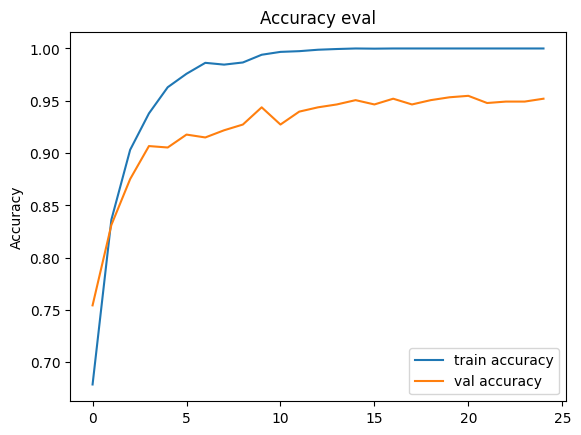

<Figure size 1000x500 with 0 Axes>

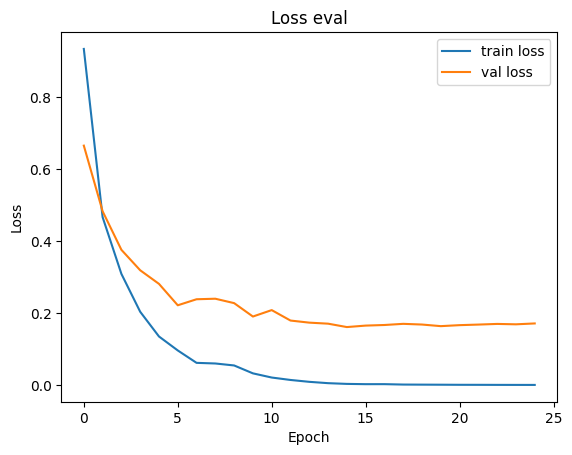

<Figure size 1000x500 with 0 Axes>

In [11]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print("Train accuracy: {:5.2f}%".format(100 * train_acc[-1]))
print("Train loss: {:5.2f}%".format(100 * train_loss[-1]))
print("Validation accuracy: {:5.2f}%".format(100 * val_acc[-1]))
print("Validation loss: {:5.2f}%".format(100 * val_loss[-1]))
print("Test accuracy: {:5.2f}%".format(100 * test_acc))
print("Test loss: {:5.2f}%".format(100 * test_loss))
acc_plot(history)
loss_plot(history)

23/23 [==============================] - 1s 25ms/step
Confusion Matrix:


<Axes: >

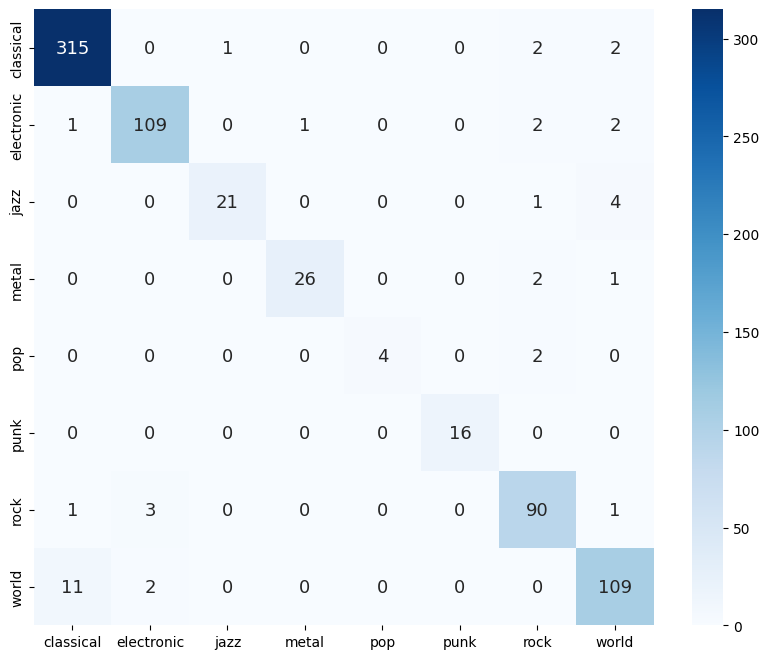

In [17]:
y_pred = model.predict(X_test)
genre_labels = data["mapping"]
confusion = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix:')

plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='g', xticklabels=genre_labels, yticklabels=genre_labels, annot_kws={"size": 13})

In [13]:
print('Classification Report')

print(classification_report(y_test, y_pred.argmax(axis=1), target_names=genre_labels))

Classification Report
              precision    recall  f1-score   support

   classical       0.96      0.98      0.97       320
  electronic       0.96      0.95      0.95       115
        jazz       0.95      0.81      0.88        26
       metal       0.96      0.90      0.93        29
         pop       1.00      0.67      0.80         6
        punk       1.00      1.00      1.00        16
        rock       0.91      0.95      0.93        95
       world       0.92      0.89      0.90       122

    accuracy                           0.95       729
   macro avg       0.96      0.89      0.92       729
weighted avg       0.95      0.95      0.95       729

